In [1]:
# -*- coding: utf-8 -*-

# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt

# for date and month formats in french or german
import locale

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
# import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display

# set the locale to the language desired
# the locale is set back to to original at the the end of the script
loc = locale.getlocale()
lang =  'de_CH.utf8'
locale.setlocale(locale.LC_ALL, lang)

# the date is in iso standard:
d = "%Y-%m-%d"

# it gets changed to german format
g = "%d.%m.%Y"

# set some parameters:
start_date = "01.03.2020"
end_date ="31.05.2021"
start_end = [start_date, end_date]
a_fail_rate = 50
unit_label = "p/100 m"
a_color = "saddlebrown"

# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette

# set the maps
bassin_map = "resources/maps/survey_areas/rhone_scaled.jpeg"

# top level aggregation
top = "Alle Erhebungsgebiete"
top_name = ["Alle Erhebungsgebiete"]

# define the feature level and components
this_feature = {'slug':'rhone', 'name':"Erhebungsgebiet Rhône", 'level':'river_bassin'}
this_level = 'water_name_slug'
this_bassin = "rhone"
bassin_label = "Erhebungsgebiet Rhône"

lakes_of_interest = ['lac-leman']
# explanatory variables:
luse_exp =  list(sut.luse_ge.values())

# common aggregations
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

# aggregation of dimensional data
agg_dims = {"total_w":"sum", "mac_plast_w":"sum", "area":"sum", "length":"sum"}

# columns needed
use_these_cols = ["loc_date" ,
                  "% to buildings",
                  "% to trans", 
                  "% to recreation",
                  "% to agg",
                  "% to woods",
                  "population",
                  this_level,
                  "streets km",
                  "intersects",
                  "length",
                  "groupname",
                  "code"
                 ]

# get your data:
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# map water_name_slug to water_name
wname_wname = dfBeaches[["water_name_slug","water_name"]].reset_index(drop=True).drop_duplicates().set_index("water_name_slug")

dfCodes.set_index("code", inplace=True)

# the surveyor designated the object as aluminum instead of metal
dfCodes.loc["G708", "material"] = "Metal"

# language specific
# importing german code descriptions
de_codes = pd.read_csv("resources/codes_german_Version_1.csv")
de_codes.set_index("code", inplace=True)

for x in dfCodes.index:
    dfCodes.loc[x, "description"] = de_codes.loc[x, "german"]

# there are long code descriptions that may need to be shortened for display
codes_to_change = [
    ["G704", "description", "Seilbahnbürste"],
    ["G30", "description", "Snack-Verpackungen"],
    ["G124", "description", "Kunststoff-oder Schaumstoffprodukte"],
    ["G87", "description", "Abdeckklebeband/Verpackungsklebeband"],
    ["G3","description","Einkaufstaschen, Shoppingtaschen"],
    ["G33", "description", "Einwegartikel; Tassen/Becher & Deckel"],
    ["G31", "description", "Schleckstengel, Stengel von Lutscher"],
    ["G211", "description", "Sonstiges medizinisches Material"],
    ["G904", "description", "Feuerwerkskörper; Raketenkappen"],
    ["G940", "description", "Schaumstoff EVA (flexibler Kunststoff)"]
]

# apply changes
for x in codes_to_change:
    dfCodes = sut.shorten_the_value(x, dfCodes)

# translate the material column
dfCodes["material"] = dfCodes.material.map(lambda x: sut.mat_ge[x]) 

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code materials
code_material_map = dfCodes.material

(rhonesade)=
# Rhône

<a href="rhone_sa.html"> English </a>

*__Unten:__ Karte des Erhebungsgebiets März 2020 - Mai 2021. Durchmesser der Punktsymbole = das mittlere Erhebungsergebnis in gefundene Abfallobjekte pro 100 Meter (p/100 m).*

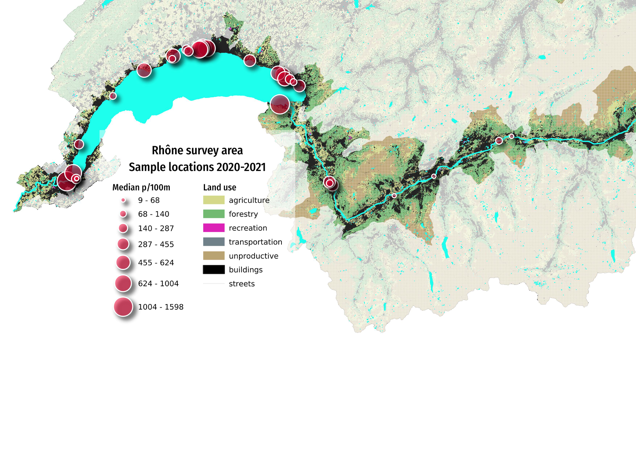

In [2]:
sut.display_image_ipython(bassin_map, thumb=(800,450))

## Erhebungsorte und Landnutzungsmerkmale 

In [3]:
# this is the data before the expanded foams and fragmented plastics are aggregated to Gfrags and Gfoams
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")

# this is the aggregated survey data that is being used
# a_data is all the data in the survey period
a_data = pd.read_csv(F"resources/checked_sdata_eos_2020_21.csv")

# apply local date configuration
a_data["date"] = pd.to_datetime(a_data.date)
a_data["date"] = a_data["date"].dt.strftime(g)
a_data["date"] = pd.to_datetime(a_data["date"], format=g)

# rename the code groups and columns to local
a_data["groupname"] = a_data["groupname"].map(lambda x: sut.group_names_de[x])
# rename the units per foen spec
a_data.rename(columns={"p/100m":unit_label}, inplace=True)
# german land use categories
a_data.rename(columns=sut.luse_ge, inplace=True)

fd = sut.feature_data(a_data, this_feature["level"], these_features=[this_feature["slug"]])

# cumulative statistics for each code
code_totals = sut.the_aggregated_object_values(fd, agg=agg_pcs_median, description_map=code_description_map, material_map=code_material_map)    

# daily survey totals
dt_all = fd.groupby(["loc_date","location",this_level, "city","date"], as_index=False).agg(agg_pcs_quantity )

# the materials table
fd_mat_totals = sut.the_ratio_object_to_total(code_totals)

# summary statistics, nsamples, nmunicipalities, names of citys, population
t = sut.make_table_values(fd, col_nunique=["location", "loc_date", "city"], col_sum=["quantity"], col_median=[])

# make a map to the population values for each survey location/city
fd_pop_map = dfBeaches.loc[fd.location.unique()][["city", "population"]].copy()
fd_pop_map.drop_duplicates(inplace=True)

# update t with the population data
t.update(sut.make_table_values(fd_pop_map, col_nunique=["city"], col_sum=["population"], col_median=[]))

# update t with the list of locations from fd
t.update({"locations":fd.location.unique()})

# the lake and river names in the survey area
lakes = dfBeaches.loc[(dfBeaches.index.isin(t["locations"]))&(dfBeaches.water == "l")]["water_name"].unique()
rivers = dfBeaches.loc[(dfBeaches.index.isin(t["locations"]))&(dfBeaches.water == "r")]["water_name"].unique()

# join the strings into comma separated list
obj_string = locale.format_string('%d', int(t["quantity"]), grouping=True)
surv_string = locale.format_string('%d', int(t["loc_date"]), grouping=True)
pop_string = locale.format_string('%d', int(t["population"]), grouping=True)


# make strings
date_quantity_context = f"Für den Zeitraum zwischen {start_date[3:]} und {end_date[3:]}, wurden im Rahmen von {surv_string}  Datenerhebungen insgesamt {obj_string} Objekte entfernt und identifiziert."
geo_context = F"Die Ergebnisse des {bassin_label}s umfassen {t['location']} Orte,  {t['city']} Gemeinden und eine Gesamtbevölkerung von etwa {pop_string} Einwohnern."
munis_joined = ", ".join(sorted(fd_pop_map["city"]))
lakes_joined = ", ".join(sorted(lakes))
rivers_joined = ", ".join(sorted(rivers))

# put that all together:
lake_string = F"""
{date_quantity_context} {geo_context}

*Seen:*\n\n >{lakes_joined}

*Fliessgewässer:*\n\n >{rivers_joined}

*Gemeinden:*\n\n >{munis_joined}
"""
md(lake_string)


Für den Zeitraum zwischen 03.2020 und 05.2021, wurden im Rahmen von 106  Datenerhebungen insgesamt 28’454 Objekte entfernt und identifiziert. Die Ergebnisse des Erhebungsgebiet Rhônes umfassen 32 Orte,  18 Gemeinden und eine Gesamtbevölkerung von etwa 488’138 Einwohnern.

*Seen:*

 >Lac Léman

*Fliessgewässer:*

 >Rhône

*Gemeinden:*

 >Allaman, Bourg-en-Lavaux, Genève, Gland, La Tour-de-Peilz, Lausanne, Lavey-Morcles, Leuk, Montreux, Préverenges, Riddes, Saint-Gingolph, Saint-Sulpice (VD), Salgesch, Sion, Tolochenaz, Versoix, Vevey


### Landnutzungsprofil der Erhebungsorte 

Die Landnutzung wird als Prozentsatz der Gesamtfläche angegeben, die jeder Landnutzungskategorie innerhalb eines Radius von 1'500 m um den Erhebungsort zugeordnet wird. 

Strassen werden als Gesamtzahl der Strassenkilometer im Umkreis von 1'500 m angegeben. Flussmündung ist ebenfalls eine ordinale Rangfolge der Anzahl der Fliessgewässer/Kanäle, die einen See innerhalb von 1'500 m um den Erhebungsort herum durchqueren. 

Das Verhältnis der Anzahl der Erhebungen bei unterschiedlichen Landnutzungsprofilen gibt einen Hinweis auf die ökologischen und wirtschaftlichen Rahmenbedingungen der Untersuchungsstandorte.  

Für weitere Informationen [_Landnutzungsprofil_](luseprofilede).

*__Unten:__ Landnutzungsprofil der Erhebungsorte. Verteilung der Erhebungen in Bezug auf die Landnutzung.*

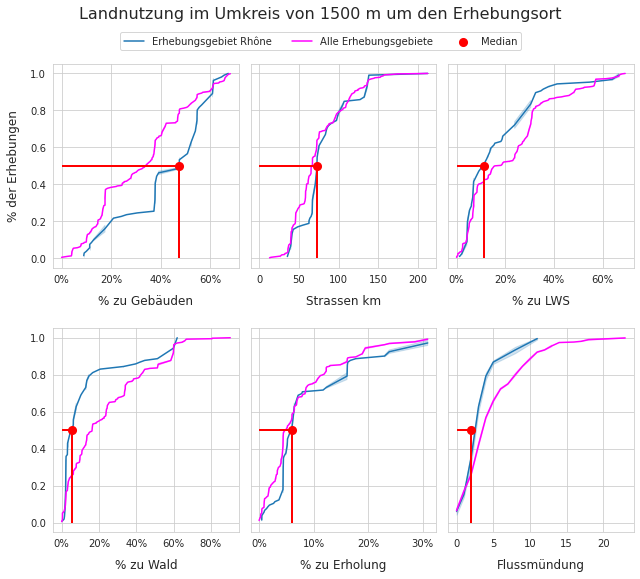

In [4]:
# the ratio of samples with respect to the different land use characteristics for each survey area
# the data to use is the unique combinations of loc_date and the land_use charcteristics of each location
project_profile = a_data[["loc_date", this_feature["level"], *luse_exp]].drop_duplicates()
dt_nw = fd[["loc_date", this_feature["level"], *luse_exp]].drop_duplicates()

# labels and levels
comps = [this_feature["slug"]]
comp_labels = {x:wname_wname.loc[x][0] for x in fd[this_level].unique()}

sns.set_style("whitegrid")

fig, axs = plt.subplots(2, 3, figsize=(9,8), sharey="row")

for i, n in enumerate(luse_exp):
    r = i%2
    c = i%3
    ax=axs[r,c]
    for element in[this_feature["slug"]]:
        data=dt_nw[dt_nw[this_feature["level"]] == element][n].values
        the_data = ECDF(data)
        
        # plot that
        sns.lineplot(x=the_data.x, y=the_data.y, ax=ax, label=bassin_label)
    
    # get the dist for all here
    a_all_surveys =  ECDF(project_profile[n].values)
    
    # plot that    
    sns.lineplot(x=a_all_surveys.x, y=a_all_surveys.y, ax=ax, label=top, color="magenta")
    
    # get the median from the data
    the_median = np.median(data)
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 0.5, color="red",s=50, linewidth=2, zorder=100, label="Median")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color="red", linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color="red", linewidth=2)
    
    if i <= 3:
        if i == 0:            
            ax.set_ylabel("% der Erhebungen", **ck.xlab_k)
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0, 0, "%"))        
    else:
        pass      
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()    
    ax.set_xlabel(list(sut.luse_ge.values())[i], **ck.xlab_k)

plt.tight_layout()
plt.subplots_adjust(top=.9, hspace=.3)
plt.suptitle("Landnutzung im Umkreis von 1500 m um den Erhebungsort", ha="center", y=1, fontsize=16)
fig.legend(handles, labels, bbox_to_anchor=(.5,.94), loc="center", ncol=3)    

plt.show()  

### Kumulative Gesamtmengen nach Gewässer 

In [5]:
# aggregate the dimensional data
dims_parameters = dict(this_level=this_level, 
                       locations=fd.location.unique(), 
                       start_end=start_end, 
                       agg_dims=agg_dims)

dims_table = sut.gather_dimensional_data(dfDims, **dims_parameters)

# map the qauntity to the dimensional data
q_map = fd.groupby("water_name_slug").quantity.sum()

# collect the number of samples from the survey total data:
for name in dims_table.index:
    dims_table.loc[name, "samples"] = fd[fd[this_level] == name].loc_date.nunique()
    dims_table.loc[name, "quantity"] = q_map[name]

# add proper names for display
dims_table["water_feature"] = dims_table.index.map(lambda x: comp_labels[x])
dims_table.set_index("water_feature", inplace=True)
   
# get the sum of all survey areas
dims_table.loc[this_feature["name"]]= dims_table.sum(numeric_only=True, axis=0)

# for display
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)
dims_table.rename(columns={"samples":"Erhebungen","quantity":"Objekte", "total_w":"Gesamt-kg", "mac_plast_w":"kg Plastik", "area":"m²", "length":"Meter"}, inplace=True)
# locale.format_string('%d', int(t["quantity"]), grouping=True)
# format kilos
dims_table["kg Plastik"] = dims_table["kg Plastik"]/1000
dims_table[["m²", "Meter", "Erhebungen", "Objekte"]] = dims_table[["m²", "Meter", "Erhebungen", "Objekte"]].applymap(lambda x: f"{locale.format_string('%d', int(x), grouping=True)}")
dims_table[["kg Plastik", "Gesamt-kg"]] = dims_table[["kg Plastik", "Gesamt-kg"]].applymap(lambda x: "{:.2f}".format(x))

# figure caption
agg_caption = F"""
*__Unten:__  Die kumulierten Gewichte und Merkmale für das {this_feature["name"]}und dessen Gewässer.*
"""
md(agg_caption)


*__Unten:__  Die kumulierten Gewichte und Merkmale für das Erhebungsgebiet Rhôneund dessen Gewässer.*


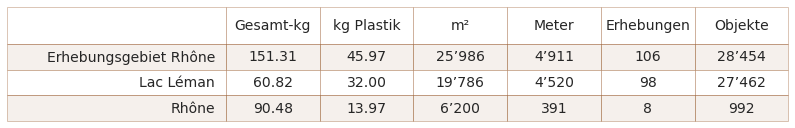

In [6]:
# make table
data = dims_table.reset_index()
colLabels = data.columns

fig, ax = plt.subplots(figsize=(len(colLabels)*2,len(data)*.7))
sut.hide_spines_ticks_grids(ax)

table_one = sut.make_a_table(ax, data.values, colLabels=colLabels, colWidths=[.28, *[.12]*6], a_color=a_color)
table_one.get_celld()[(0,0)].get_text().set_text(" ")
table_one.set_fontsize(14)

plt.show()
plt.tight_layout()
plt.close()

### Verteilung der Erhebungsergebnisse

In [7]:
# the surveys to chart
fd_dindex = dt_all.set_index("date")

# all the other surveys
ots = dict(level_to_exclude=this_feature["level"], components_to_exclude=fd[this_feature["level"]].unique())
dts_date = sut.the_other_surveys(a_data, **ots)
dts_date.head()

# the survey totals from all other survey areas
dts_date = dts_date.groupby(["loc_date","date"], as_index=False)[unit_label].sum()
dts_date.set_index("date", inplace=True)

# get the monthly or quarterly results for the feature
resample_plot, rate = sut.quarterly_or_monthly_values(fd_dindex , this_feature["name"], vals=unit_label, quarterly=["ticino"])

# scale the chart as needed to accomodate for extreme values
y_lim = 99
y_limit = np.percentile(dts_date[unit_label], y_lim)

# label for the chart that alerts to the scale
not_included = F"Werte grösser als {locale.format_string('%d', round(y_limit, 1), grouping=True)} {unit_label} werden nicht gezeigt."

# figure caption
chart_notes = F"""
*__Links:__ {this_feature["name"]}, {start_date[3:]} bis {end_date[3:]}, n={t["loc_date"]}. {not_included} __Rechts:__ {this_feature["name"]} empirische kumulative Verteilung der Datenerhebungen.*
"""
md(chart_notes )


*__Links:__ Erhebungsgebiet Rhône, 03.2020 bis 05.2021, n=106. Werte grösser als 1’360 p/100 m werden nicht gezeigt. __Rechts:__ Erhebungsgebiet Rhône empirische kumulative Verteilung der Datenerhebungen.*


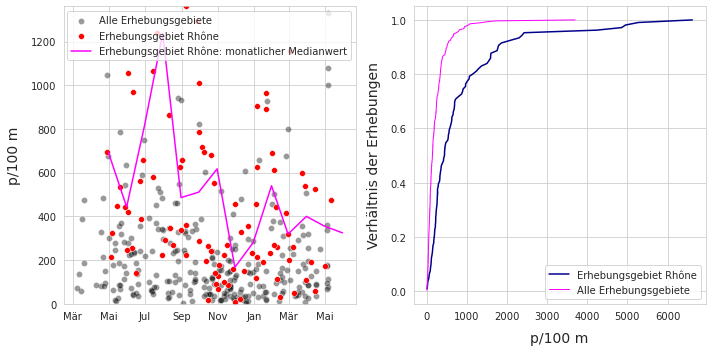

In [8]:
# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)

fig, axs = plt.subplots(1,2, figsize=(10,5))

# the survey totals by day
ax = axs[0]

# feature surveys
sns.scatterplot(data=dts_date, x=dts_date.index, y=unit_label, label=top, color="black", alpha=0.4,  ax=ax)
# all other surveys
sns.scatterplot(data=fd_dindex, x=fd_dindex.index, y=unit_label, label=this_feature["name"], color="red", s=34, ec="white", ax=ax)

# monthly or quaterly plot
sns.lineplot(data=resample_plot, x=resample_plot.index, y=resample_plot, label=F"{this_feature['name']}: monatlicher Medianwert", color="magenta", ax=ax)

ax.set_ylim(0,y_limit )
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.legend()

# the cumlative distributions:
axtwo = axs[1]

# the feature of interest
feature_ecd = ECDF(dt_all[unit_label].values)    
sns.lineplot(x=feature_ecd.x, y=feature_ecd.y, color="darkblue", ax=axtwo, label=this_feature["name"])

# the other features
other_features = ECDF(dts_date[unit_label].values)
sns.lineplot(x=other_features.x, y=other_features.y, color="magenta", label=top, linewidth=1, ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Verhältnis der Erhebungen", **ck.xlab_k14)

plt.tight_layout()
plt.show()

### Zusammengefasste Daten und Materialarten 

In [9]:
# figure caption


summary_of_survey_totals = F"""
*__Links:__ Zusammenfassung der Daten aller Erhebungen im {this_feature["name"]}. __Rechts:__ Gefundene Materialarten im {this_feature["name"]} und Prozentsatz deren Gesamtmenge.*
"""
md(summary_of_survey_totals)


*__Links:__ Zusammenfassung der Daten aller Erhebungen im Erhebungsgebiet Rhône. __Rechts:__ Gefundene Materialarten im Erhebungsgebiet Rhône und Prozentsatz deren Gesamtmenge.*


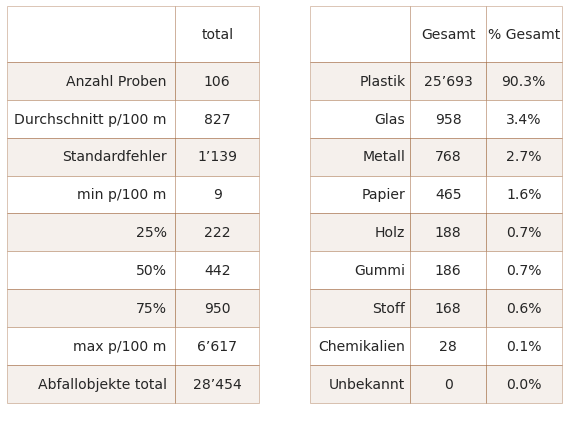

In [10]:
# get the basic statistics from pd.describe
cs = dt_all[unit_label].describe().round(2)

# add project totals
cs["total objects"] = dt_all.quantity.sum()

# change the names
csx = sut.change_series_index_labels(cs, sut.create_summary_table_index(unit_label, lang="DE"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])

fd_mat_totals = sut.fmt_pct_of_total(fd_mat_totals)
fd_mat_totals = sut.make_string_format(fd_mat_totals)

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Quantity", "% of total":"% of total"}
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values

# make tables
fig, axs = plt.subplots(1,2, figsize=(8,6))

# summary table
# names for the table columns
a_col = [this_feature["name"], "total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")
table_two.set_fontsize(14)

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

# column names for display
cols_to_use = {"material":"Material","quantity":"Gesamt", "% of total":"% Gesamt"}

table_three = sut.make_a_table(axtwo, fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_three.get_celld()[(0,0)].get_text().set_text(" ")
table_three.set_fontsize(14)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

## Die am häufigsten gefundenen Gegenstände

Die am häufigsten gefundenen Gegenstände sind die zehn mengenmässig am meisten vorkommenden Objekte UND/ODER Objekte, die in mindestens 50% aller Datenerhebungen identifiziert wurden (fail-rate). 

In [11]:
# the top ten by quantity
most_abundant = code_totals.sort_values(by="quantity", ascending=False)[:10]

# the most common
most_common = code_totals[code_totals["fail rate"] >= a_fail_rate].sort_values(by="quantity", ascending=False)

# merge with most_common and drop duplicates
m_common = pd.concat([most_abundant, most_common]).drop_duplicates()

# get percent of total
m_common_percent_of_total = m_common.quantity.sum()/code_totals.quantity.sum()

# figure caption
rb_string = F"""
*__Unten:__ Häufigste Objekte im {this_feature["name"]}: fail-rate >/= 50% und/oder Top Ten nach Anzahl. Zusammengenommen machen die häufigsten Objekte {int(m_common_percent_of_total*100)}% aller gefundenen Objekte aus. Anmerkung: {unit_label} = Medianwert der Erhebung.*
"""
md(rb_string)


*__Unten:__ Häufigste Objekte im Erhebungsgebiet Rhône: fail-rate >/= 50% und/oder Top Ten nach Anzahl. Zusammengenommen machen die häufigsten Objekte 79% aller gefundenen Objekte aus. Anmerkung: p/100 m = Medianwert der Erhebung.*


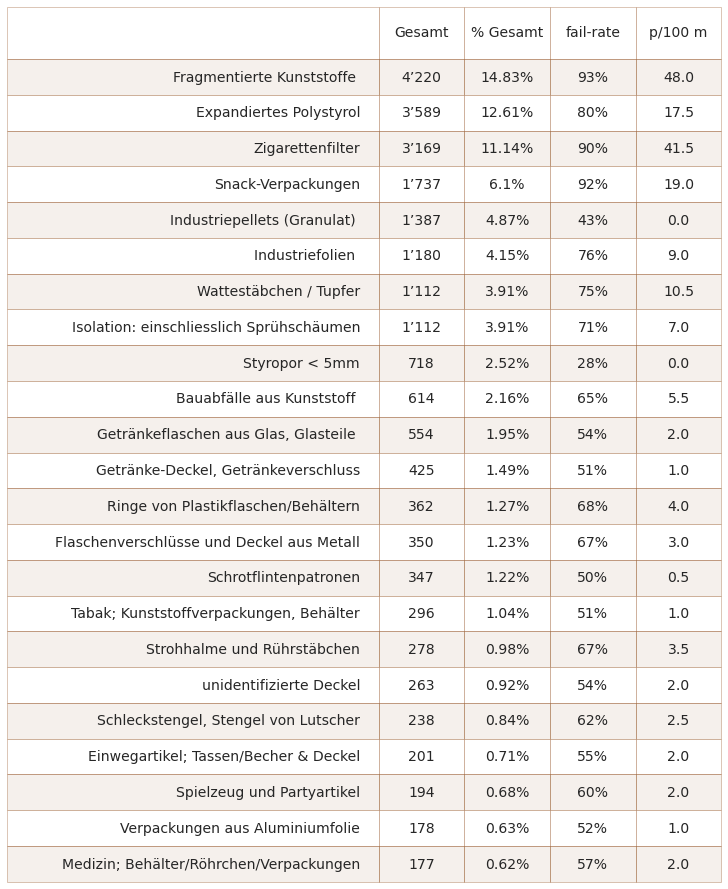

In [12]:
# format values for table
m_common["item"] = m_common.index.map(lambda x: code_description_map.loc[x])
m_common["% of total"] = m_common["% of total"].map(lambda x: F"{x}%")
m_common["quantity"] = m_common.quantity.map(lambda x: f"{locale.format_string('%d', x, grouping=True)}")
m_common["fail rate"] = m_common["fail rate"].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: F"{round(x,1)}")

cols_to_use = {"item":"Objekt","quantity":"Gesamt", "% of total":"% Gesamt", "fail rate":"fail-rate", unit_label:unit_label}
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(12.8,len(m_common)*.7))

sut.hide_spines_ticks_grids(axs)

table_four = sut.make_a_table(axs, all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.52, .12,.12,.12, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_four.get_celld()[(0,0)].get_text().set_text(" ")
table_four.set_fontsize(14)

plt.show()
plt.tight_layout()
plt.close()

### Die am häufigsten gefundenen Gegenstände nach Gewässer 

In [13]:
rb_string = F"""
*__Unten:__ häufigste Objekte im {this_feature["name"]}: Median {unit_label}.*
"""
md(rb_string)


*__Unten:__ häufigste Objekte im Erhebungsgebiet Rhône: Median p/100 m.*


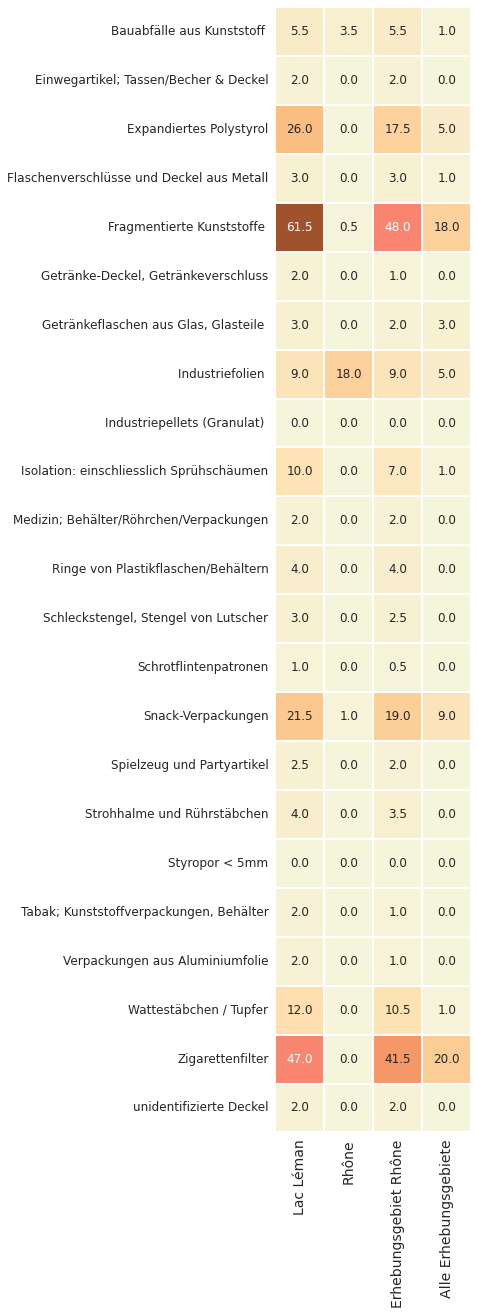

In [14]:
# aggregated survey totals for the most common codes for all the water features
m_common_st = fd[fd.code.isin(m_common.index)].groupby([this_level, "loc_date","code"], as_index=False).agg(agg_pcs_quantity)
m_common_ft = m_common_st.groupby([this_level, "code"], as_index=False)[unit_label].median()

# proper name of water feature for display
m_common_ft["f_name"] = m_common_ft[this_level].map(lambda x: comp_labels[x])

# map the desctiption to the code
m_common_ft["item"] = m_common_ft.code.map(lambda x: code_description_map.loc[x])

# pivot that
m_c_p = m_common_ft[["item", unit_label, "f_name"]].pivot(columns="f_name", index="item")

# quash the hierarchal column index
m_c_p.columns = m_c_p.columns.get_level_values(1)

# the aggregated totals for the survey area
c = sut.aggregate_to_group_name(fd[fd.code.isin(m_common.index)], column="code", name=this_feature["name"], val="med", unit_label=unit_label)

m_c_p[this_feature["name"]]= sut.change_series_index_labels(c, {x:code_description_map.loc[x] for x in c.index})

# the aggregated totals of all the data
c = sut.aggregate_to_group_name(a_data[(a_data.code.isin(m_common.index))], column="code", name=top, val="med", unit_label=unit_label)
m_c_p[top] = sut.change_series_index_labels(c, {x:code_description_map.loc[x] for x in c.index})

# chart that
fig, ax  = plt.subplots(figsize=(len(m_c_p.columns)*.9,len(m_c_p)*.9))
axone = ax

sns.heatmap(m_c_p, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".1f", square=True, cbar=False, linewidth=.1, linecolor="white")
axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="x")
axone.tick_params(labelsize=12, which="both", axis="y")

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
plt.close()

### Die am häufigsten gefundenen Gegenstände im monatlichen Durchschnitt

In [15]:
# collect the survey results of the most common objects
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(["loc_date","date","code", "groupname"], as_index=False).agg(agg_pcs_quantity)
m_common_m.set_index("date", inplace=True)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(["code","groupname"], as_index=False).quantity.sum().sort_values(by="groupname")["code"].values

# a manager dict for the monthly results of each code
mgr = {}

# get the monhtly results for each code:
for a_group in an_order:
    # resample by month
    a_plot = m_common_m[(m_common_m.code==a_group)][unit_label].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

monthly_mc = F"""
*__Unten:__ {this_feature["name"]}, monatliche Durchschnittsergebnisse {unit_label}.*
"""
md(monthly_mc)


*__Unten:__ Erhebungsgebiet Rhône, monatliche Durchschnittsergebnisse p/100 m.*


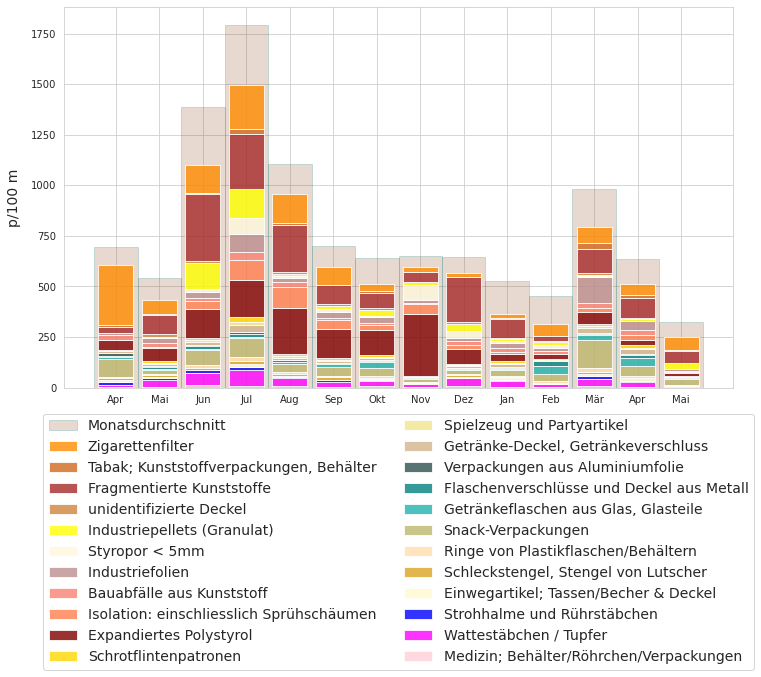

In [16]:
months={
    0:"Jan",
    1:"Feb",
    2:"Mar",
    3:"Apr",
    4:"May",
    5:"Jun",
    6:"Jul",
    7:"Aug",
    8:"Sep",
    9:"Oct",
    10:"Nov",
    11:"Dec"
}

# convenience function to lable x axis
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

fig, ax = plt.subplots(figsize=(12,7))

# define a bottom
bottom = [0]*len(mgr["G27"])

# the monhtly survey average for all objects and locations
monthly_fd = fd.groupby(["loc_date", "date"], as_index=False).agg(agg_pcs_quantity)
monthly_fd.set_index("date", inplace=True)
m_fd = monthly_fd[unit_label].resample("M").mean().fillna(0)

# define the xaxis
this_x = [i for i,x in  enumerate(m_fd.index)]

# plot the monthly total survey average
ax.bar(this_x, m_fd.to_numpy(), color=a_color, alpha=0.2, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average") 

# plot the monthly survey average of the most common objects
for i, a_group in enumerate(an_order): 
    
    # define the axis
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    
    # collect the month
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    # if i == 0 laydown the first bars
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    # else use the previous results to define the bottom
    else:
        bottom += mgr[an_order[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)
        
# collect the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# set the location of the x ticks
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))
ax.set_ylabel(unit_label, **ck.xlab_k14)

#label the xticks by month
axisticks = ax.get_xticks()
labelsx = [sut.months_de[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# make the legend
# swap out codes for descriptions
new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]

# insert a label for the monthly average
new_labels.insert(0,"Monatsdurchschnitt")
handles = [handles[0], *handles[1:][::-1]]
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(.5, -.05), loc="upper center",  ncol=2, fontsize=14)       
plt.show()

## Erhebungsergebnisse und Landnutzung 

Der Flächennutzungsmix ist eine einzigartige Darstellung der Art und des Umfangs der wirtschaftlichen Aktivität und der Umweltbedingungen rund um den Erhebungsort. Die Schlüsselindikatoren aus den Ergebnissen der Datenerhebungen werden mit den Flächennutzungsraten für einen Radius von 1500 m um den Erhebungsort verglichen. 

Eine Assoziation ist eine Beziehung zwischen den Ergebnissen der Datenerhebungen und dem Landnutzungsprofil, die nicht auf Zufall beruht. Das Ausmass der Beziehung ist weder definiert noch linear. 

Die Rangkorrelation ist ein nicht-parametrischer Test, um festzustellen, ob ein statistisch signifikanter Zusammenhang zwischen der Landnutzung und den bei einer Abfallobjekte-Erhebung identifizierten Objekten besteht.  

Die verwendete Methode ist der Spearman’s rho oder Spearmans geordneter Korrelationskoeffizient. Die Testergebnisse werden bei p<0,05 für alle gültigen Erhebungen an Seen im Untersuchungsgebiet ausgewertet.

1. Rot/Rosa ist eine positive Assoziation 
2. Gelb ist eine negative Assoziation 
3. Weiss ist keine statistische Grundlage für die Annahme eines Zusammenhangs, p>0,05 

In [17]:
corr_data = fd[(fd.code.isin(m_common.index))&(fd.water_name_slug.isin(lakes_of_interest))].copy()

alert_less_than_100 = len(corr_data.loc_date.unique()) <= 100

if alert_less_than_100:
    warning = F"""**Da es weniger als 100 Erhebungen gibt, ist Vorsicht geboten. Erhebungen über Strand-Abfallobjekte weisen eine grosse Streuung auf!**"""
else:
    warning = ""

association = F"""*Unten: Ausgewertete Korrelation der am häufigsten gefundenen Objekte in Bezug auf das Landnutzungsprofil im {this_feature["name"]}. Für alle gültigen Erhebungen an Seen n={len(corr_data.loc_date.unique())}.*

{warning}
"""
md(association)

*Unten: Ausgewertete Korrelation der am häufigsten gefundenen Objekte in Bezug auf das Landnutzungsprofil im Erhebungsgebiet Rhône. Für alle gültigen Erhebungen an Seen n=98.*

**Da es weniger als 100 Erhebungen gibt, ist Vorsicht geboten. Erhebungen über Strand-Abfallobjekte weisen eine grosse Streuung auf!**


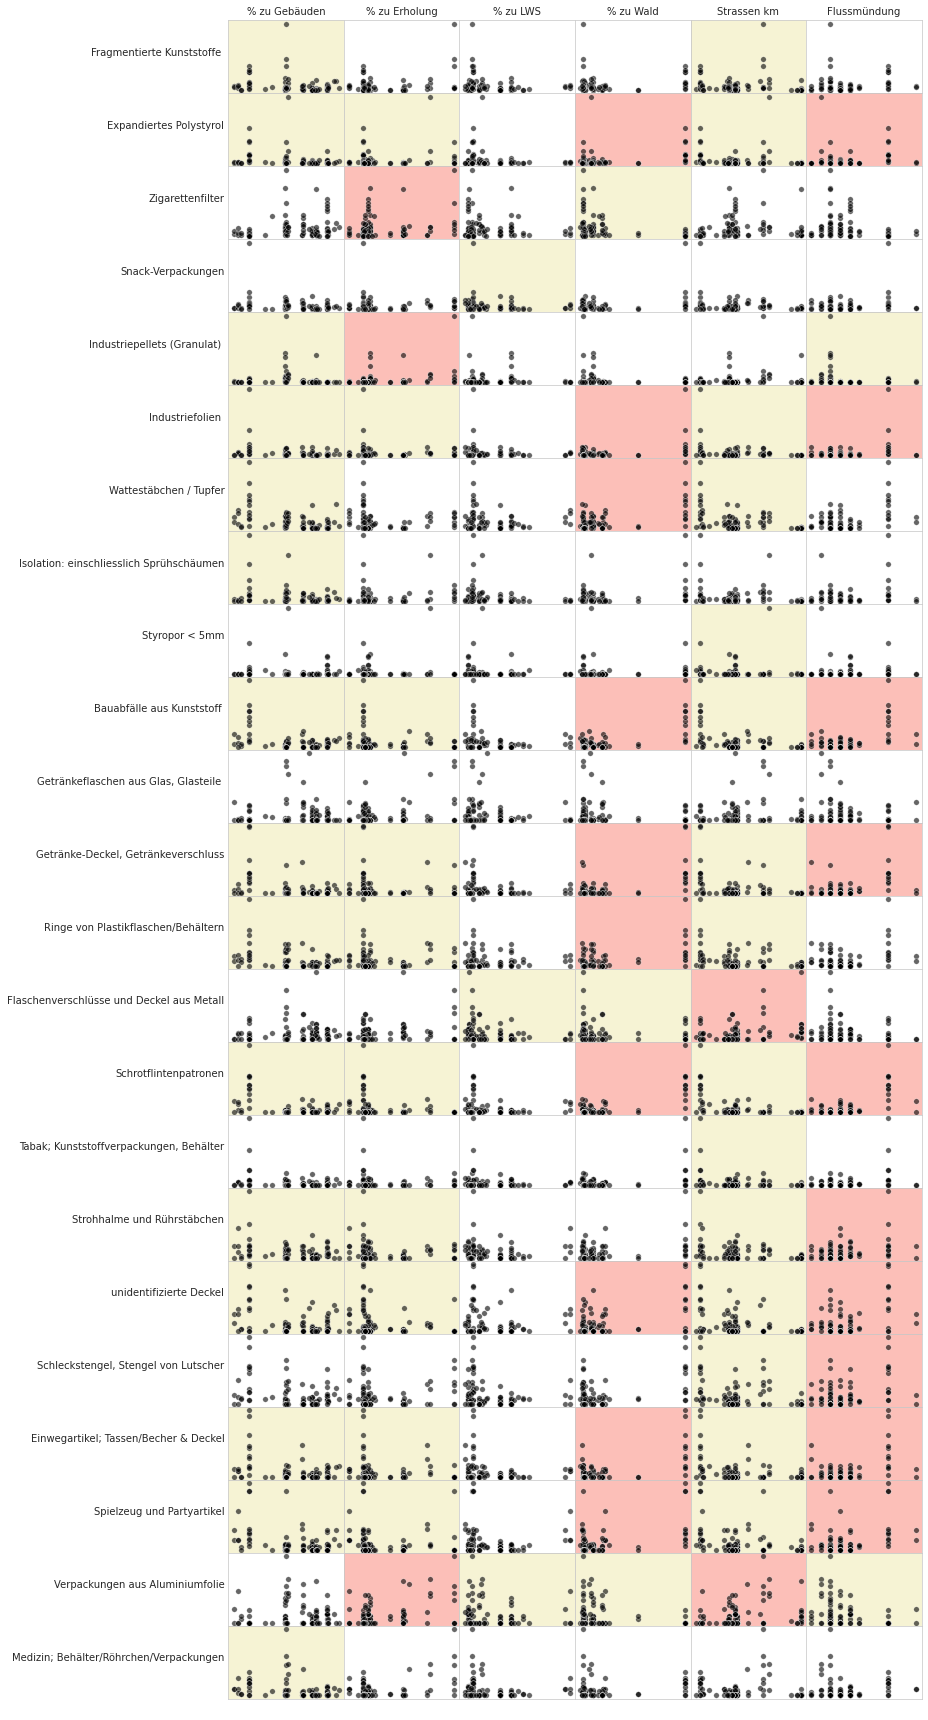

In [18]:
# chart the results of test for association
fig, axs = plt.subplots(len(m_common.index),len(luse_exp), figsize=(len(luse_exp)+7,len(m_common.index)+1), sharey="row")

# the test is conducted on the survey results for each code
for i,code in enumerate(m_common.index):
    # slice the data
    data = corr_data[corr_data.code == code]
    
    # run the test on for each land use feature
    for j, n in enumerate(luse_exp):       
        # assign ax and set some parameters
        ax=axs[i, j]
        ax.grid(False)
        ax.tick_params(axis="both", which="both",bottom=False,top=False,labelbottom=False, labelleft=False, left=False)
        
        # check the axis and set titles and labels       
        if i == 0:
            ax.set_title(F"{n}", fontsize=10)
        else:
            pass
        
        if j == 0:
            ax.set_ylabel(F"{code_description_map[code]}", rotation=0, ha="right", fontsize=10)
            ax.set_xlabel(" ")
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
        # run test
        _, corr, a_p = sut.make_plot_with_spearmans(data, ax, n, unit_label=unit_label)
        
        # if siginficant set adjust color to direction
        if a_p < 0.05:
            if corr > 0:
                ax.patch.set_facecolor("salmon")
                ax.patch.set_alpha(0.5)
            else:
                ax.patch.set_facecolor("palegoldenrod")
                ax.patch.set_alpha(0.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

*Legende: wenn p >0,05 = weiss, wenn p < 0,05 und rho > 0 = rot, wenn p < 0,05 und rho < 0 = gelb*

## Verwendungszweck der gefundenen Objekte 

Die Nutzungsart basiert auf der Verwendung des Objekts, bevor es weggeworfen wurde, oder auf der Artikelbeschreibung, wenn die ursprüngliche Verwendung unbestimmt ist. Identifizierte Objekte werden einer der 260 vordefinierten Kategorien zugeordnet. Die Kategorien werden je nach Verwendung oder Artikelbeschreibung gruppiert. 

*  **Abwasser:** Gegenstände, die aus Kläranlagen freigesetzt werden, einschliesslich Gegenstände, die wahrscheinlich über die Toilette entsorgt werden   
*  **Mikroplastik (< 5 mm):** fragmentierte Kunststoffe und Kunststoffharze aus der Vorproduktion
*  **Infrastruktur:** Artikel im Zusammenhang mit dem Bau und der Instandhaltung von Gebäuden, Strassen und der Wasser-/Stromversorgung  
*  **Essen und Trinken:** alle Materialien, die mit dem Konsum von Essen und Trinken in Zusammenhang stehen
*  **Landwirtschaft:**     z. B. für Mulch und Reihenabdeckungen, Gewächshäuser, Bodenbegasung, Ballenverpackungen. Einschliesslich Hartkunststoffe für landwirtschaftliche Zäune, Blumentöpfe usw. 
*  **Tabakwaren:** hauptsächlich Zigarettenfilter, einschliesslich aller mit dem Rauchen verbundenen Materialien 
*  **Freizeit und Erholung:** Objekte, die mit Sport und Freizeit zu tun haben, z. B. Angeln, Jagen, Wandern usw. 
*  **Verpackungen ausser Lebensmittel und Getränke:**     Verpackungsmaterial, das nicht lebensmittel-, getränke- oder tabakbezogen ist
*  **Plastikfragmente:** Plastikteile unbestimmter Herkunft oder Verwendung  
*  **Persönliche Gegenstände:** Accessoires, Hygieneartikel und Kleidung 

Im Anhang finden Sie die vollständige Liste der identifizierten Objekte, einschliesslich Beschreibungen und Gruppenklassifizierung. Der Abschnitt [Codegruppen](codegroupsde) beschreibt jede Codegruppe im Detail und bietet eine umfassende Liste aller Objekte in einer Gruppe. 

In [19]:
cg_poft = F"""
<br></br>
*__Unten:__ Verwendungszweck oder Beschreibung der identifizierten Objekte in % der Gesamtzahl nach Gewässer im {this_feature["name"]}. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.*
"""
md(cg_poft)


<br></br>
*__Unten:__ Verwendungszweck oder Beschreibung der identifizierten Objekte in % der Gesamtzahl nach Gewässer im Erhebungsgebiet Rhône. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.*


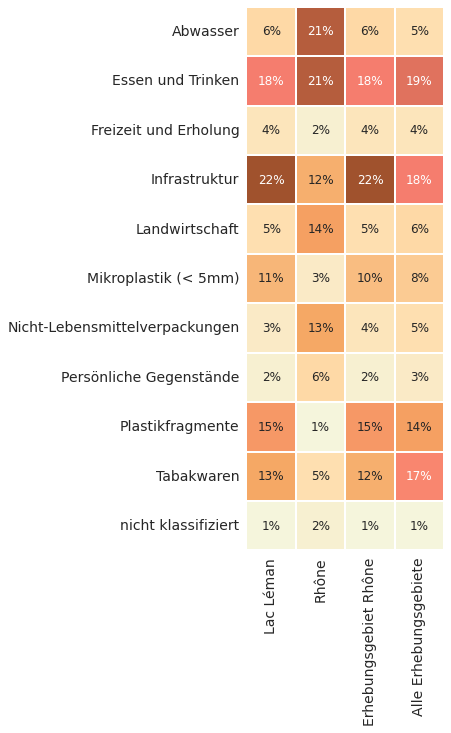

In [20]:
# code groups resluts aggregated by survey
groups = ["loc_date","groupname"]
cg_t = fd.groupby([this_level,*groups], as_index=False).agg(agg_pcs_quantity)

# the total per water feature
cg_tq = cg_t.groupby(this_level).quantity.sum()

# get the fail rates for each group per survey
cg_t["fail"]=False
cg_t["fail"] = cg_t.quantity.where(lambda x: x == 0, True)

# aggregate all that for each municipality
agg_this = {unit_label:"median", "quantity":"sum", "fail":"sum", "loc_date":"nunique"} 
cg_t = cg_t.groupby([this_level, "groupname"], as_index=False).agg(agg_this)

# assign survey area total to each record
for a_feature in cg_tq.index:
    cg_t.loc[cg_t[this_level] == a_feature, "f_total"] = cg_tq.loc[a_feature]

# get the percent of total for each group for each survey area
cg_t["pt"] = (cg_t.quantity/cg_t.f_total).round(2)

# pivot that
data_table = cg_t.pivot(columns=this_level, index="groupname", values="pt")

# repeat for the survey area
data_table[bassin_label] = sut.aggregate_to_group_name(fd, unit_label=unit_label, column="groupname", name=bassin_label, val="pt")

# repeat for all the data
data_table[top] = sut.aggregate_to_group_name(a_data, unit_label=unit_label, column="groupname", name=top, val="pt")

data = data_table
data.rename(columns={x:wname_wname.loc[x][0] for x in data.columns[:-2]}, inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, cbar=False, fmt=".0%", linewidth=.1, square=True, linecolor="white")

axone.set_ylabel("")
axone.set_xlabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

In [21]:
cg_medpcm = F"""
<br></br>
*__Unten:__ Verwendungszweck der gefundenen Objekte Median {unit_label} im {this_feature["name"]}. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.*
"""
md(cg_medpcm)


<br></br>
*__Unten:__ Verwendungszweck der gefundenen Objekte Median p/100 m im Erhebungsgebiet Rhône. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.*


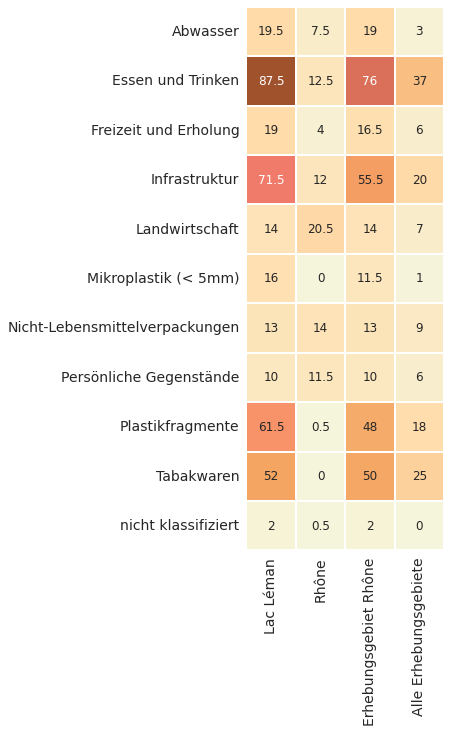

In [22]:
# median p/50m of all the water features
data_table = cg_t.pivot(columns="water_name_slug", index="groupname", values=unit_label)

# the survey area columns
data_table[bassin_label] = sut.aggregate_to_group_name(fd, unit_label=unit_label, column="groupname", name=bassin_label, val="med")

# column for all the surveys
data_table[top] = sut.aggregate_to_group_name(a_data, unit_label=unit_label, column="groupname", name=top, val="med")

# merge with data_table
data = data_table
data.rename(columns={x:wname_wname.loc[x][0] for x in data.columns[:-2]}, inplace=True)
fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt="g", cbar=False, linewidth=.1, square=True, linecolor="white")

axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

## Fliessgewässer 

In [23]:
rivers = fd[fd.w_t == "r"].copy()
r_smps = rivers.groupby(["loc_date", "date", "location", "water_name_slug"], as_index=False).agg(agg_pcs_quantity)
l_smps = fd[fd.w_t == "l"].groupby(["loc_date","date","location", "water_name_slug"], as_index=False).agg(agg_pcs_quantity)

chart_notes = F"""
*__Links:__ {this_feature["name"]} Fliessgewässer, {start_date[3:]} bis {end_date[3:]}, n={len(r_smps.loc_date.unique())}. {not_included} __Rechts:__ Zusammenfassende der Daten.*
"""
md(chart_notes )


*__Links:__ Erhebungsgebiet Rhône Fliessgewässer, 03.2020 bis 05.2021, n=8. Werte grösser als 1’360 p/100 m werden nicht gezeigt. __Rechts:__ Zusammenfassende der Daten.*


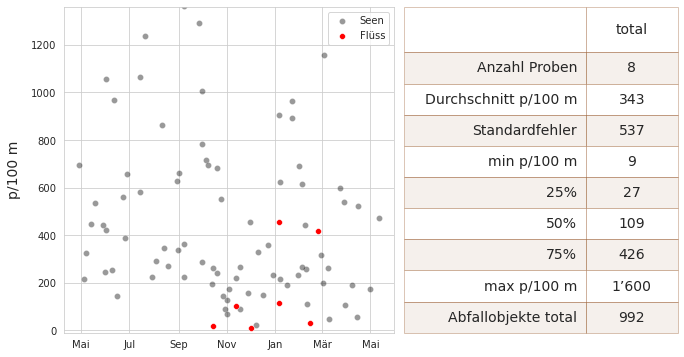

In [24]:
cs = r_smps[unit_label].describe().round(2)

# add project totals
cs["total objects"] = r_smps.quantity.sum()

# change the names
csx = sut.change_series_index_labels(cs, sut.create_summary_table_index(unit_label, lang="DE"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])

# make the charts
fig = plt.figure(figsize=(11,6))

aspec = fig.add_gridspec(ncols=11, nrows=3)

ax = fig.add_subplot(aspec[:, :6])

line_label = F"{rate} median:{top}"

sns.scatterplot(data=l_smps, x="date", y=unit_label, color="black", alpha=0.4, label="Seen", ax=ax)
sns.scatterplot(data=r_smps, x="date", y=unit_label, color="red", s=34, ec="white",label="Flüss", ax=ax)

ax.set_ylim(-10,y_limit )

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)

a_col = [this_feature["name"], "total"]

axone = fig.add_subplot(aspec[:, 6:])
sut.hide_spines_ticks_grids(axone)

table_five = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_five.get_celld()[(0,0)].get_text().set_text(" ")
table_five.set_fontsize(14)

plt.show()

### Die an Fliessgewässern am häufigsten gefundenen Objekte

In [25]:
riv_mcommon = F"""
*Häufigste Objekte {unit_label} an Fliessgewässer im {this_feature["name"]}:  Medianwert der Erhebung.*
"""
md(riv_mcommon)


*Häufigste Objekte p/100 m an Fliessgewässer im Erhebungsgebiet Rhône:  Medianwert der Erhebung.*


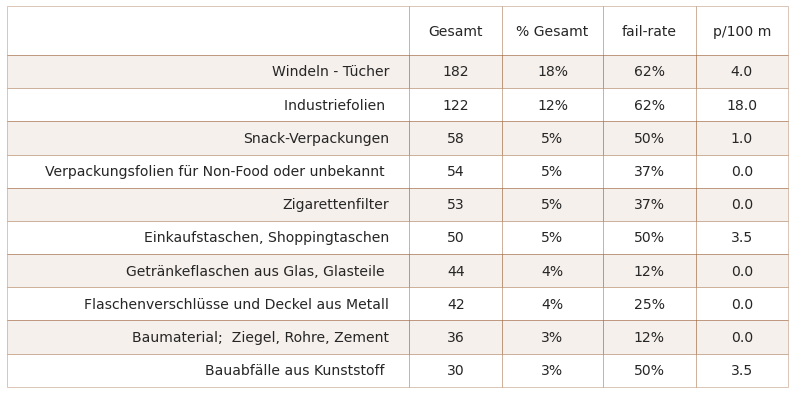

In [26]:
# the most common items rivers
colLabels=list(cols_to_use.values())
r_codes = rivers.groupby("code").agg({"quantity":"sum", "fail":"sum", unit_label:"median"})
r_codes["fail rate"] = (r_codes.fail/r_smps.loc_date.nunique()*100).astype("int")

# top ten
r_byq = r_codes.sort_values(by="quantity", ascending=False)[:10].index

# most common
r_byfail = r_codes[r_codes["fail rate"] >= a_fail_rate].index
r_most_common = list(set(r_byq) | set(r_byfail))

# format for display
r_mc= r_codes.loc[r_most_common].copy()
r_mc["item"] = r_mc.index.map(lambda x: code_description_map.loc[x])
r_mc.sort_values(by="quantity", ascending=False, inplace=True)

r_mc["% of total"]=((r_mc.quantity/r_codes.quantity.sum())*100).astype("int")
r_mc["% of total"] = r_mc["% of total"].map(lambda x: F"{x}%")
r_mc["quantity"] = r_mc.quantity.map(lambda x: "{:,}".format(x))
r_mc["fail rate"] = r_mc["fail rate"].map(lambda x: F"{x}%")
r_mc["p/50m"] = r_mc[unit_label].map(lambda x: F"{np.ceil(x)}")
r_mc.rename(columns=cols_to_use, inplace=True)

data=r_mc[list(cols_to_use.values())]

fig, axs = plt.subplots(figsize=(14,len(data)*.7))

sut.hide_spines_ticks_grids(axs)

table_six = sut.make_a_table(axs, data.values,  colLabels=list(data.columns), colWidths=[.52, .12,.13,.12, .12], **{"loc":"lower center"})
table_six.get_celld()[(0,0)].get_text().set_text(" ")
table_six.set_fontsize(14)

plt.show()
plt.tight_layout()
plt.close()

## Anhang

### Schaumstoffe und Kunststoffe nach Grösse 

Die folgende Tabelle enthält die Komponenten "Gfoam" und "Gfrags", die für die Analyse gruppiert wurden. Objekte, die als Schaumstoffe gekennzeichnet sind, werden als Gfoam gruppiert und umfassen alle geschäumten Polystyrol-Kunststoffe > 0,5 cm.  Kunststoffteile und Objekte aus kombinierten Kunststoff- und Schaumstoffmaterialien > 0,5 cm werden für die Analyse als Gfrags gruppiert. 

In [27]:
frag_foams = F"""
*__Unten:__ Fragmentierte und geschäumte Kunststoffe nach Grösse im {this_feature["name"]}, Median p/100 m, Anzahl der gefundenen Stücke und Prozent der Gesamtmenge.*
"""
md(frag_foams)


*__Unten:__ Fragmentierte und geschäumte Kunststoffe nach Grösse im Erhebungsgebiet Rhône, Median p/100 m, Anzahl der gefundenen Stücke und Prozent der Gesamtmenge.*


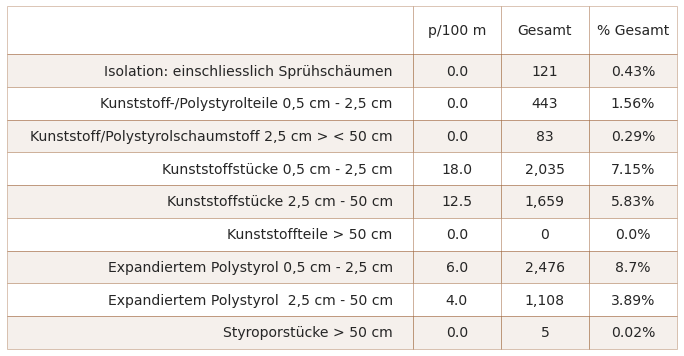

In [28]:
# collect the data before aggregating foams for all locations in the survye area
# group by loc_date and code
# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ["G81", "G82", "G83", "G74"]

# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == "plastic pieces"].code.unique())
before_agg.rename(columns={"p/100m":unit_label}, inplace=True)

fd_frags_foams = before_agg[(before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(t["locations"]))].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code").agg(agg_pcs_median)


# add code description and format for printing
fd_frags_foams["item"] = fd_frags_foams.index.map(lambda x: code_description_map.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams["% of total"] = fd_frags_foams["% of total"].map(lambda x: F"{x}%")
fd_frags_foams["quantity"] = fd_frags_foams["quantity"].map(lambda x: F"{x:,}")

# table data
data = fd_frags_foams[["item",unit_label, "quantity", "% of total"]]
data.rename(columns={"quantity":"Gesamt", "% of total":"% Gesamt"}, inplace=True)

fig, axs = plt.subplots(figsize=(12,len(data)*.7))

sut.hide_spines_ticks_grids(axs)

table_seven = sut.make_a_table(axs,data.values,  colLabels=data.columns, colWidths=[.6, .13, .13, .13], a_color=a_color)
table_seven.get_celld()[(0,0)].get_text().set_text(" ")
table_seven.set_fontsize(14)

plt.show()
plt.tight_layout()
plt.close()

### Die Erhebungsorte

In [29]:
# display the survey locations
disp_columns = ["latitude", "longitude", "city"]
disp_beaches = dfBeaches.loc[t["locations"]][disp_columns]
new_names = {"slug":"Standort", "city":"Stadt"}
disp_beaches.reset_index(inplace=True)
disp_beaches.rename(columns=new_names, inplace=True)
disp_beaches.set_index("Standort", inplace=True, drop=True)


disp_beaches

,latitude,longitude,Stadt
Standort,,,
maladaire,46.446296,6.876960,La Tour-de-Peilz
preverenges,46.512690,6.527657,Préverenges
vidy-ruines,46.516221,6.596279,Lausanne
baby-plage-geneva,46.208558,6.162923,Genève
grand-clos,46.387746,6.843686,Saint-Gingolph
quai-maria-belgia,46.460156,6.836718,Vevey
anarchy-beach,46.447216,6.859612,La Tour-de-Peilz
lavey-les-bains-2,46.207726,7.011685,Lavey-Morcles
leuk-mattenstrasse,46.314754,7.622521,Leuk


### Inventar der Objekte

In [30]:
pd.set_option("display.max_rows", None)
complete_inventory = code_totals[code_totals.quantity>0][["item", "groupname", "quantity", "% of total","fail rate"]]

new_names = {"item":"Objekte", "groupname":"Gruppenname", "quantity":"Menge", "fail rate":"Fail-Pass", "% of total":"% Gesamt", }

complete_inventory.rename(columns=new_names, inplace=True)
complete_inventory.sort_values(by="Menge", ascending=False)

,Objekte,Gruppenname,Menge,% Gesamt,Fail-Pass
code,,,,,
Gfrags,Fragmentierte Kunststoffe,Plastikfragmente,4220,14.83,93
Gfoam,Expandiertes Polystyrol,Infrastruktur,3589,12.61,80
G27,Zigarettenfilter,Tabakwaren,3169,11.14,90
G30,Snack-Verpackungen,Essen und Trinken,1737,6.10,92
G112,Industriepellets (Granulat),Mikroplastik (< 5mm),1387,4.87,43
G67,Industriefolien,Landwirtschaft,1180,4.15,76
G74,Isolation: einschliesslich Sprühschäumen,Infrastruktur,1112,3.91,71
G95,Wattestäbchen / Tupfer,Abwasser,1112,3.91,75
G117,Styropor < 5mm,Mikroplastik (< 5mm),718,2.52,28
